In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
import pickle
import seaborn as sns
import multiprocessing
os.environ["PYTHONWARNINGS"] = 'ignore'# 'ignore::sklearn.exceptions.ConvergenceWarning:sklearn.model_selection.GridSearchCV'
#os.environ["OMP_NUM_THREADS"] = 1

In [2]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time

In [4]:
# dask cluster location
cluster_loc = 'hpc'
prefix = 'transect'
tuneby = 'year'

inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_' + prefix + '_hls_idxs.csv'

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'



var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'savi', 'rdvi', 'mtvi1', 'nci', 'ndci', 'psri', 'ndwi', 'evi', 'tcbi', 'tcgi', 'tcwi',
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

var_dv1 = ['NDVI', 'NDII7', 'SAVI', 'RDVI', 'MTVI1', 'PSRI', 'NDWI', 'EVI', 'TCGI']

include_dv1 = False

rand_st = 2313

In [5]:
if cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    from jupyter_server import serverapp
    # get the server address for porting
    try:
        jupServer = [x for x in serverapp.list_running_servers()][0]
    except IndexError:
        # manually copy/paste the server address
        jupServer = {'base_url': '/node/ceres19-compute-98-eth.scinet.local/17710/'}
    print('   setting up cluster on HPC...')
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='scavenger-gpu',#'brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            project='cper_neon_aop',
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory='12GB',
                            #interface='ib0',
                            #interface='ens7f0',
                            scheduler_options={'interface': 'enp24s0f0'},
                            local_directory='$TMPDIR',
                            death_timeout=60,
                            walltime='02:00:00',
                            job_extra_directives=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=12
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes*0.1, timeout=60)
    except dask.distributed.TimeoutError as e:
        print('workers may not be available. Diplaying client with currently available workers.')
        #print(e)
        pass
    display(client)
    backend = 'dask'
else:
    backend = 'threading'

   setting up cluster on HPC...
workers may not be available. Diplaying client with currently available workers.


<Client: 'tcp://10.1.4.125:40857' processes=4 threads=8, memory=11.16 GiB>

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
#from xgboost import XGBRegressor

if backend == 'dask':
    #from dask_ml.xgboost import XGBRegressor
    from dask_ml.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
else:
    from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from skorch import NeuralNetRegressor

In [8]:
#import sys
#sys.path.insert(0, '/project/cper_neon_aop/cper_hls_veg_models/models/dnn_architectures')

#import dnn

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

In [10]:
#df_results = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results.csv"))
#df_results_full = pd.read_csv(os.path.join(outDIR, "VOR_lreg_results_full.csv"))

In [11]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [12]:
if 'dvi' in inFILE:
    if include_dv1:
        for i in var_dv1:
            var_dict[i + '_dv1'] = var_dict[i] + '_dv1'
            var_names.append(var_dict[i] + '_dv1')
    else:
        df_vor = df_vor.drop(columns=[i + '_dv1' for i in var_dv1])

In [13]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [14]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [15]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [16]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

In [17]:
if False:
    sns.displot(x='Biomass_kg_ha', col='Year', col_wrap=3, hue='Season', data=df_vor, height=3, aspect=1.5)

In [18]:
if False:
    g = sns.lmplot(x='tcwi', y='Biomass_kg_ha', scatter=True, hue='Pasture', ci=None, data=df_vor)
    g.set(yscale="log")

In [19]:
if False:
    corrMatrix = X_vars_all.reset_index(drop=True).join(Y_var_all.reset_index(drop=True)).corr()
    plt.figure(figsize=(14, 12))
    plt.suptitle('All')
    sns.heatmap(corrMatrix, annot=True)
    #plt.show()

In [20]:
if False:
    fig, axs = plt.subplots(figsize=(16, 20),
                            nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
    for idx, v in enumerate(var_names):
        xy_bm = np.vstack([df_vor[v], df_vor['Biomass_kg_ha']])
        z_bm = gaussian_kde(xy_bm)(xy_bm)
        df_vor.plot.scatter(x=v, y='Biomass_kg_ha', logy=True, ax=axs.flatten()[idx], ylim=(25, 7000),
                                c=z_bm, cmap='magma', colorbar=False)
        plt.tight_layout(pad=1.0)

In [21]:
if backend == 'dask':
    print(len(client.nthreads()))
else:
    print(multiprocessing.cpu_count())

4


In [22]:
scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

In [24]:
if torch.has_cuda:
    device='cuda'
else:
    device='cpu'

In [25]:
# THIS WORKED, but failed at end of grid search 
# try Basically, either remove the %load_ext; %autoreload 2 in the notebook or put the definition of DNNRegressor in a separate module/Python file.
# as stated: https://github.com/dask/dask-ml/issues/549
class DNNRegressor(nn.Module):
    def __init__(self, n_layers=3):
        super().__init__()
        self.layers = []
        self.acts = []
        for i in range(n_layers):
            self.layers.append(nn.Linear(len(var_names), len(var_names)))
            self.acts.append(nn.ReLU())
            self.add_module(f"layer{i}", self.layers[-1])
            self.add_module(f"act{i}", self.acts[-1])
        self.output = nn.Linear(len(var_names), 1)
 
    def forward(self, x):
        for layer, act in zip(self.layers, self.acts):
            x = act(layer(x))
        x = self.output(x)
        return x

dnnr = NeuralNetRegressor(
            DNNRegressor,
            criterion=nn.L1Loss,
            optimizer=optim.Adam,
            lr=0.0001,
            max_epochs=150,
            batch_size=10,
            train_split=None,
            verbose=False, 
    device=device)

In [26]:
mod_dict = {
    'OLS_2022': {
        'base_mod': 'Biomass_kg_ha ~ ndii7 + nir + bai_236 + ndii7:nir + ndii7:bai_236 + nir:bai_236',
        'fit': False,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
    },
    'OLS': {
        'base_mod': 'Biomass_kg_ha ~ ',
        'fit': False,
        'tune': True,
        'tune_refit': 'mae_orig_mean',
        'tune_refit_type': 'minimize',
        'variable_importance': False,
        'scale_x': False,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'formula_df': pd.DataFrame(columns=['year', 'numb_vars', 'formula', 'R2_adj', 'AIC', 'mae_orig_mean'])
    },
    'LASSO': {
        'base_mod': Lasso(),
        'fit': False,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'alpha': np.logspace(-3, 1, num=30)
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': True,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'Coef'])
    },
    'PLS': {
        'base_mod': PLSRegression(n_components=1, scale=False),
        'fit': False,
        'tune': True,
        'tune_vip': False,
        'tune_vip_iters': 3,
        'tune_vip_thresh': [0.8, 0.8, 0.8],
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'VIP', 'Coef'])
    },
    'PCR': {
        'base_mod': make_pipeline(PCA(), LinearRegression()),
        'fit': False,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'pca__n_components': np.arange(1, len(var_names))
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': True,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable'] + ['PC_' + str(i+1) for i in range(len(var_names))])
    },
    'SVR': {
        'base_mod': SVR(kernel='linear'),
        'fit': False,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'C': np.logspace(1.5, 4, 10, base=10),
            'gamma': np.logspace(-3.5, 0, 10, base=10)
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'RF': {
        'base_mod': RandomForestRegressor(n_estimators=200, bootstrap=True, oob_score=True, n_jobs=-1),
        'fit': False,
        'tune': True,
        'variable_importance': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'min_samples_split': [0.0001, 0.001, 0.005, 0.01],
            #'n_estimators': [400],
            'max_samples': [0.2, 0.3, 0.5, 0.7, 0.9],
            'max_features': [0.1, 0.25, 0.5, 0.75, 1.0]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'GBR': {
        #'base_mod': XGBRegressor(n_jobs=-1, verbosity=0),
        'base_mod': GradientBoostingRegressor(loss='absolute_error'),
        'fit': False,
        'variable_importance': True,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'learning_rate': [0.01, 0.05, 0.1],
            'min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05, 0.10],
            #'max_depth': [3, 6, 9],
            #'min_child_weight': [10, 100, 200, 400],
            'n_estimators': [100, 200, 400],
            'max_features': [0.1, 0.25, 0.5]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame(columns=['Year', 'Variable', 'PI'])
    },
    'MLP': {
        'base_mod': MLPRegressor(solver='adam', activation='logistic', hidden_layer_sizes=(256,),
                                 max_iter=1000, learning_rate='adaptive'),
        'fit': False,
        'variable_importance': False,
        'tune': False,
        'tune_refit': 'MAPE',
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (150,)],
            'alpha': [0.00005, 0.0001, 0.0005, 0.001]
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
    },
    'DNN2': {
        'base_mod': dnnr,
        'fit': True,
        'variable_importance': False,
        'tune': True,
        'tune_refit': 'MAPE',
        'param_grid': {
            'module__n_layers': [3], 
            'lr': [0.01, 0.001],
            'max_epochs': [100, 150],
        },
        'tune_results': {},
        'scale_x': True,
        'log_y': False,
        'interactions': False,
        'interaction_only': True,
        'interaction_poly': 2,
        'variable_df': pd.DataFrame()
    }
}

In [27]:
DNN_old = {
        # see https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
        'base_mod': nn.Sequential(
            nn.Linear(len(var_names), len(var_names)*3),
            nn.ReLU(),
            nn.Linear(len(var_names)*3, len(var_names)*3//2),
            nn.ReLU(),
            nn.Linear(len(var_names)*3//2, len(var_names)*3//2//2),
            nn.ReLU(),
            nn.Linear(len(var_names)*3//2//2, 1)
        ),
        'fit': True,
        'loss': nn.L1Loss(),
        'n_epochs': 100,
        'batch_size': 10,
        'variable_importance': False,
        'tune': False,
        'scale_x': True,
        'log_y': False,
        'interactions': False
    }

In [28]:
#client.restart()

In [29]:
@dask.delayed
def fit_ols(all_x, split_groups, df_train, lr_form, yr, idx):
    r2_adj_tmp = []
    aic_tmp = []
    mae_orig_tmp = []
    for train_index_sub, test_index_sub in mod_logo.split(all_x, groups=split_groups):
        df_train_sub = df_train.iloc[train_index_sub]
        df_test_sub = df_train.iloc[test_index_sub]
        lreg_k_tmp = smf.ols(formula=lr_form, data=df_train_sub).fit()
        r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
        aic_tmp.append(lreg_k_tmp.aic)
        mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test_sub) - df_test_sub['Biomass_kg_ha'])))
    df_results_tmp = pd.DataFrame(dict(year=[yr],
                                       numb_vars=[k_fold],
                                       formula=[lr_form],
                                       R2_adj=round(np.mean(r2_adj_tmp), 4),
                                       AIC=round(np.mean(aic_tmp), 4),
                                       mae_orig_mean=round(np.mean(mae_orig_tmp), 4)),
                                 index=[idx])
    return df_results_tmp


In [30]:
for k in mod_dict:
    if mod_dict[k]['fit']:
        df_vor[k] = np.nan

for train_index, test_index in mod_logo.split(X_vars_all, groups=df_vor['Date'].dt.year, ):
    yr = df_vor['Date'].dt.year.iloc[test_index].unique()[0]
    print("Running K-fold = " + str(yr))

    train_loc = df_vor.iloc[train_index].index
    test_loc = df_vor.iloc[test_index].index
    
    all_y_orig = df_vor['Biomass_kg_ha'].iloc[train_index]
    all_Y_orig = df_vor['Biomass_kg_ha'].iloc[test_index]
    all_x_orig = df_vor[var_names].iloc[train_index, :]
    all_X_orig = df_vor[var_names].iloc[test_index, :]

    for k in mod_dict:
        if mod_dict[k]['fit']:
            print('....fitting ' + k, end = " ")
            t0 = time.time()
            
            # prep data
            if mod_dict[k]['log_y']:
                all_y = np.log(1 + all_y_orig)
                all_Y = np.log(1 + all_Y_orig)
            else:
                all_y = all_y_orig.copy()
                all_Y = all_Y_orig.copy()
            if mod_dict[k]['scale_x']:
                scaler.fit(all_x_orig)
                all_x = scaler.transform(all_x_orig)
                all_X = scaler.transform(all_X_orig)
            else:
                all_x = all_x_orig.copy()
                all_X = all_X_orig.copy()
            
            if mod_dict[k]['interactions']:
                poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                            interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                all_x = poly_x.fit_transform(all_x)
                poly_X = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                            interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
                all_X = poly_X.fit_transform(all_X)
                var_names_out = poly_x.get_feature_names_out(var_names)
            else:
                var_names_out = var_names

            if k == 'DNN2':
                all_x = all_x.astype('float32')
                all_y = all_y.astype('float32').values.reshape(-1, 1)
                all_X = all_X.astype('float32')
                all_Y = all_Y.astype('float32')
                client.scatter([DNNRegressor, dnnr], broadcast=True)
            
            if k == 'DNN':
                mod_base = nn.Sequential(
                    nn.Linear(len(var_names), len(var_names)*3),
                    nn.ReLU(),
                    nn.Linear(len(var_names)*3, len(var_names)*3//2),
                    nn.ReLU(),
                    nn.Linear(len(var_names)*3//2, len(var_names)*3//2//2),
                    nn.ReLU(),
                    nn.Linear(len(var_names)*3//2//2, 1)
                )
                # Convert to 2D PyTorch tensors
                all_x = torch.tensor(all_x, dtype=torch.float32)
                all_y = torch.tensor(all_y.values, dtype=torch.float32).reshape(-1, 1)
                all_X = torch.tensor(all_X, dtype=torch.float32)
                all_Y = torch.tensor(all_Y.values, dtype=torch.float32).reshape(-1, 1)
                
                # loss function and optimizer
                loss_fn = mod_dict[k]['loss']
                optimizer = optim.Adam(mod_base.parameters(), lr=0.0001)
                batch_start = torch.arange(0, len(all_x), mod_dict[k]['batch_size'])
                
                # Hold the best model
                best_mae = np.inf   # init to infinity
                best_weights = None
                history = []
                 
                for epoch in range(mod_dict[k]['n_epochs']):
                    mod_base.train()
                    with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                        bar.set_description(f"Epoch {epoch}")
                        for start in bar:
                            # take a batch
                            X_batch = all_x[start:start+mod_dict[k]['batch_size']]
                            y_batch = all_y[start:start+mod_dict[k]['batch_size']]
                            # forward pass
                            y_pred = mod_base(X_batch)
                            loss = loss_fn(y_pred, y_batch)
                            # backward pass
                            optimizer.zero_grad()
                            loss.backward()
                            # update weights
                            optimizer.step()
                            # print progress
                            bar.set_postfix(mae=float(loss))
                    # evaluate accuracy at end of each epoch
                    mod_base.eval()
                    y_pred = mod_base(all_X)
                    mae = loss_fn(y_pred, all_Y)
                    mae = float(mae)
                    history.append(mae)
                    if mae < best_mae:
                        best_mae = mae
                        best_weights = copy.deepcopy(mod_base.state_dict())
                # restore model and return best accuracy
                mod_base.load_state_dict(best_weights)
                print("MAE: %.2f" % best_mae)
                plt.plot(history)
                plt.show()

                preds = mod_base(all_X).detach().numpy()

                del mod_base, loss_fn, optimizer

            else:
                # create a base model
                mod_base = mod_dict[k]['base_mod']
                
                if mod_dict[k]['tune']:
                    if tuneby == 'year':
                        split_groups = df_vor['Date'].dt.year.iloc[train_index]
                        cv_splitter = mod_logo.split(all_x, groups=split_groups)
                    elif tuneby == 'pasture':
                        split_groups = df_vor['Pasture'].iloc[train_index]
                        cv_splitter = mod_groupk.split(all_x, groups=split_groups)
                    
                    if 'OLS' in k:
                        df_train = pd.merge(pd.DataFrame(data=all_y),
                                            pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                            left_index=True,
                                            right_index=True)
                        df_test = pd.merge(pd.DataFrame(data=all_Y),
                                            pd.DataFrame(columns=all_X_orig.columns, data=all_X, index=all_X_orig.index),
                                            left_index=True,
                                            right_index=True)
                        if k == 'OLS_2022':
                            form_fnl = mod_dict[k]['base_mod']
                        else:
                            idx = 0
                            df_results_list = []
                            for k_fold in range(1, 3 + 1):
                                for combo in itertools.combinations(var_names, k_fold):
                                    combo_corr = df_vor[np.array(combo)].corr()
                                    if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                                        continue
                                    else:
                                        lr_form = mod_dict[k]['base_mod'] + combo[0]
                                        if k_fold > 1:
                                            for c in combo[1:]:
                                                lr_form = lr_form + ' + ' + c
                                            for combo_c in itertools.combinations(combo, 2):
                                                lr_form = lr_form + ' + ' + combo_c[0] + ':' + combo_c[1]
                                        df_results_tmp = fit_ols(all_x, split_groups, df_train, lr_form, yr, idx)
                                        df_results_list.append(df_results_tmp)
                                        #mod_dict[k]['formula_df'] = pd.concat([df_results_tmp.compute(), mod_dict[k]['formula_df']])
                                        #break
                            df_results = dask.compute(df_results_list)
                            mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])
                            if mod_dict[k]['tune_refit_type'] == 'minimize':
                                tune_loc = 0
                            elif mod_dict[k]['tune_refit_type'] == 'maximize':
                                tune_loc = -1
                            form_fnl = mod_dict[k]['formula_df'][mod_dict[k]['formula_df']['year'] == yr].sort_values(
                                mod_dict[k]['tune_refit'])['formula'].iloc[tune_loc]
                        mod_fnl = smf.ols(formula=form_fnl, data=df_train).fit()
                    
                    elif k == 'MLP':
                        from sklearn.model_selection import GridSearchCV as skGridSearchCV
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        with parallel_backend('threading'):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][yr] = grid_search.cv_results_
                    else:
                        grid_search = skGridSearchCV(estimator=mod_base,
                                                       param_grid=mod_dict[k]['param_grid'],
                                                       scoring=scoring, 
                                                       refit=mod_dict[k]['tune_refit'], 
                                                       return_train_score=True,
                                                       cv=cv_splitter, 
                                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                                  len(client.nthreads())))
                        with parallel_backend(backend):
                            with warnings.catch_warnings():
                                warnings.simplefilter("ignore", category=ConvergenceWarning)
                                grid_search.fit(all_x, all_y)
                        mod_fnl = mod_base.set_params(**grid_search.best_params_)
                        mod_fnl.fit(all_x, all_y)
                        mod_dict[k]['tune_results'][yr] = grid_search.cv_results_
                else:
                    mod_fnl = mod_base
                    mod_fnl.fit(all_x, all_y)
    
                if mod_dict[k]['variable_importance']:
                    if k == 'LASSO':
                        lasso_coefs = abs(mod_fnl.coef_)
                        var_names_out = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
                        lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'Coef': lasso_coefs})])
                    if k == 'PLS':
                        pls_vip = vip(all_x, all_y, mod_fnl)
                        pls_coefs = abs(mod_fnl.coef_).squeeze()
                        if mod_dict[k]['tune_vip']:
                            if len(mod_dict[k]['tune_vip_thresh']) != mod_dict[k]['tune_vip_iters']:
                                print('ERROR: Length of tune_vip_thresh does not equal tune_vip_iters.')
                                break
                            else:
                                for i in range(mod_dict[k]['tune_vip_iters']):
                                    vip_thresh = mod_dict[k]['tune_vip_thresh'][i]
                                    all_x = all_x[:, pls_vip > vip_thresh]
                                    all_X = all_X[:, pls_vip > vip_thresh]
                                    mod_fnl.fit(all_x, all_y)
                                    var_names_out = [x for idx, x in enumerate(var_names_out) if pls_vip[idx] > vip_thresh]
                                    pls_vip = vip(all_x, all_y, mod_fnl)
                                    pls_coefs = abs(mod_fnl.coef_).squeeze()
                            
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'VIP': pls_vip,
                                                                              'Coef': pls_coefs})])
                    if k == 'PCR':
                        # get distributed coefficients by multiplying variable loadings by PC coefficients
                        coefs = pd.DataFrame(mod_fnl['pca'].components_.T  * mod_fnl['linearregression'].coef_, 
                                                columns=['PC_' + str(i+1) for i in range(grid_search.best_params_['pca__n_components'])], 
                                                index=var_names_out).reset_index().rename(columns={'index': 'Variable'})
                        coefs['Year'] = str(df_vor['Date'].dt.year.iloc[test_index].unique()[0])
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                coefs])
                        
                    if k in ['SVR', 'RF', 'GBR']:
                        rf_pi = permutation_importance(mod_fnl, all_X, all_Y, n_repeats=10, random_state=rand_st, n_jobs=-1)
                        mod_dict[k]['variable_df'] = pd.concat([mod_dict[k]['variable_df'],
                                                                pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                                              'Variable': var_names_out,
                                                                              'PI': rf_pi.importances_mean})])
                
                if mod_dict[k]['log_y']:
                    if mod_dict[k] == 'OLS':
                        preds = np.exp(mod_fnl.predict(df_train))
                    else:
                        preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
                else:
                    if mod_dict[k] == 'OLS':
                        preds = mod_fnl.predict(df_train)
                    else:
                        preds = mod_fnl.predict(all_X).squeeze()
            df_vor.loc[test_loc, k] = preds
            print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')
        else:
            continue

Running K-fold = 2013
....fitting DNN2 

TypeError: 'CancelledError' object is not iterable

In [37]:
df_vor['Year'] = df_vor['Date'].dt.year
df_vor['Pasture'] = df_vor['Id'].apply(lambda x: x.split('_')[0])
df_vor['Plot'] = df_vor['Id'].apply(lambda x: x.split('_')[1])
if len(df_vor['Id'].iloc[0].split('_')) == 3:
    df_vor['Transect'] = df_vor['Id'].apply(lambda x: x.split('_')[-1])


In [38]:
if 'Transect' in df_vor.columns:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                         id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Transect', 'Season', 'Observed'], 
                         value_name='Predicted',
                         var_name='Source')
else:
    df_bm_pred = pd.melt(df_vor.drop(columns=['Low', 'High', 'geometry', 'Date'] + var_names).rename(columns={'Biomass_kg_ha': 'Observed'}), 
                     id_vars=['Id', 'Pasture', 'Year', 'Date_mean', 'Plot', 'Season', 'Observed'], 
                     value_name='Predicted',
                     var_name='Source')
    

In [39]:
save_results=False

In [40]:
if save_results:
    df_bm_pred.to_csv('results/ml_pred_' + prefix + '_cv_year_tuneby_' + tuneby + '.csv', index=False)
    with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk', 'wb') as fp:
        pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
if 'Transect' in df_bm_pred.columns:
    mae_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
    mape_transect = df_bm_pred.groupby(['Source', 'Year']).apply(
        lambda z: z.groupby(['Pasture', 'Plot', 'Transect', 'Date_mean']).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
    r2_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
    r2_corr_transect = df_bm_pred.groupby(['Source', 'Year']).apply((lambda x: r2_corrcoef(x['Observed'], x['Predicted']))).round(2)

In [44]:
if 'Transect' in df_bm_pred.columns:
    df_smry_transect = pd.DataFrame({
        'MAE': mae_transect.unstack(level=0).mean().round(2),
        'MAPE': mape_transect.unstack(level=0).mean().round(2),
        'R^2': r2_transect.unstack(level=0).mean().round(2),
        'r^2': r2_corr_transect.unstack(level=0).mean().round(2)
    })
    display(df_smry_transect)
    if save_results:
        df_smry_transect.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.csv')

    df_smry_transect_by_yr = pd.DataFrame({
        'MAE': mae_transect.round(2),
        'MAPE': mape_transect.round(2),
        'R^2': r2_transect.round(2),
        'r^2': r2_corr_transect.round(2)
    })
    #display(df_smry_plot_by_yr)
    if save_results:
        df_smry_transect_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

,MAE,MAPE,r^2
Source,,,
DNN2,364.26,0.38,0.42


In [35]:
mae_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_plot = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Plot', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    (lambda x: r2_score(x['Observed'], x['Predicted']))).round(2)
r2_corr_plot = df_bm_pred.groupby(['Source', 'Year', 'Pasture', 'Plot']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
        lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [36]:
df_smry_plot = pd.DataFrame({
    'MAE': mae_plot.unstack(level=0).mean().round(2),
    'MAPE': mape_plot.unstack(level=0).mean().round(2),
    'R^2': r2_plot.unstack(level=0).mean().round(2),
    'r^2': r2_corr_plot.unstack(level=0).mean().round(2)
})
display(df_smry_plot)
if save_results:
    df_smry_plot.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_plot_by_yr = pd.DataFrame({
    'MAE': mae_plot.round(2),
    'MAPE': mape_plot.round(2),
    'R^2': r2_plot.round(2),
    'r^2': r2_corr_plot.round(2)
})
#display(df_smry_plot_by_yr)
if save_results:
    df_smry_plot_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

,MAE,MAPE,R^2,r^2
Source,,,,
DNN,227.57,0.29,0.47,0.61


In [ ]:
mae_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed']))).mean()).round(2)
mape_pasture = df_bm_pred.groupby(['Source', 'Year']).apply(
    lambda z: z.groupby(['Pasture', 'Date_mean']).apply(lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])) / np.mean(x['Observed'])).mean()).round(2)
r2_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_score(x['Observed'], x['Predicted'])).round(2)
r2_corr_pasture = df_bm_pred.groupby(['Source', 'Year', 'Pasture']).mean().reset_index().dropna().groupby(['Source', 'Year']).apply(
    lambda x: r2_corrcoef(x['Observed'], x['Predicted'])).round(2)

In [ ]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(2),
    'MAPE': mape_pasture.unstack(level=0).mean().round(2),
    'R^2': r2_pasture.unstack(level=0).mean().round(2),
    'r^2': r2_corr_pasture.unstack(level=0).mean().round(2)
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.csv')

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(2),
    'MAPE': mape_pasture.round(2),
    'R^2': r2_pasture.round(2),
    'r^2': r2_corr_pasture.round(2)
})
#display(df_smry_pasture_by_yr)
if save_results:
    df_smry_pasture_by_yr.to_csv('results/tables/ml_models/ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '_yearly.csv')

In [ ]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)
else:
    p_trans=None

In [ ]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3, col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'], 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby + '.png'), dpi=100)

In [ ]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable')['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
p = sns.catplot(df_lasso_coefs, x='Coef_abs', y='Variable', hue='Year', height=8, aspect=1.0, orient='h')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
df_lasso_coefs.groupby('Variable')['Coef'].count().sort_values(ascending=False)

In [ ]:
df_lasso_coefs.groupby('Year')['Coef'].count()

In [ ]:
df_vip = mod_dict['PLS']['variable_df']
df_vip_ranked = df_vip.groupby('Variable')['VIP'].mean().sort_values(ascending=False)
df_vip['Variable'] = pd.Categorical(df_vip['Variable'], categories=df_vip_ranked.index.values)
df_vip_top = df_vip[df_vip['VIP'] > 1.0].copy()
df_vip_top['Variable'] = df_vip_top['Variable'].cat.remove_unused_categories()
p = sns.catplot(df_vip_top, x='VIP', y='Variable',  hue='Year', height=8, aspect=1.0, orient='h')

In [ ]:
df_vip[df_vip['VIP'] > 1.0].groupby('Variable')['VIP'].count().sort_values(ascending=False)

In [ ]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['Year', 'Variable']).apply(lambda x: np.mean(np.abs(x), axis=1))
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable')['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

p = sns.catplot(df_pcr_coefs_mean_top20,
                x='Coef_mean_abs', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_svr_pi = mod_dict['SVR']['variable_df']
df_svr_pi_ranked = df_svr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_svr_pi['Variable'] = pd.Categorical(df_svr_pi['Variable'], categories=df_svr_pi_ranked.index.values)
p = sns.catplot(df_svr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_rf_pi = mod_dict['RF']['variable_df']
df_rf_pi_ranked = df_rf_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_rf_pi['Variable'] = pd.Categorical(df_rf_pi['Variable'], categories=df_rf_pi_ranked.index.values)
p = sns.catplot(df_rf_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
df_gbr_pi = mod_dict['GBR']['variable_df']
df_gbr_pi_ranked = df_gbr_pi.groupby('Variable')['PI'].mean().sort_values(ascending=False)
df_gbr_pi['Variable'] = pd.Categorical(df_gbr_pi['Variable'], categories=df_gbr_pi_ranked.index.values)
p = sns.catplot(df_gbr_pi,
                x='PI', y='Variable',  hue='Year', height=6, aspect=1, orient='h')

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', row='Year', col_order=['LASSO', 'PLS', 'PCR', 'RF', 'SVR', 'GBR'],
               hue='Season', ci=None, order=1,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes.flatten():
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')

In [35]:
param_dfs = {}
for k in mod_dict:
    if 'OLS' in k:
        continue
    else:
        for idx, yr in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][yr]['params']]))
                param_dfs[k] = pd.DataFrame(columns=['Model', 'Year', 'Best', 'MAPE', 'MSE', 'R2', 'R2_train'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'Year': yr,
                                   'Best': 0,
                                   'MAPE': mod_dict[k]['tune_results'][yr]['mean_test_MAPE'],
                                   'MSE': mod_dict[k]['tune_results'][yr]['mean_test_MSE'],
                                   'R2': mod_dict[k]['tune_results'][yr]['mean_test_R2'],
                                   'R2_train': mod_dict[k]['tune_results'][yr]['mean_train_R2']})
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][yr]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][yr]['rank_test_MAPE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

In [ ]:
sns.catplot(x='alpha', y='MAPE', data=param_dfs['LASSO'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_components', y='MAPE', data=param_dfs['PLS'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='pca__n_components', y='MAPE', data=param_dfs['PCR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_samples', y='MSE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
param_dfs['RF']['max_features'][param_dfs['RF']['max_features'].isnull()] = 'None'
sns.catplot(x='max_features', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

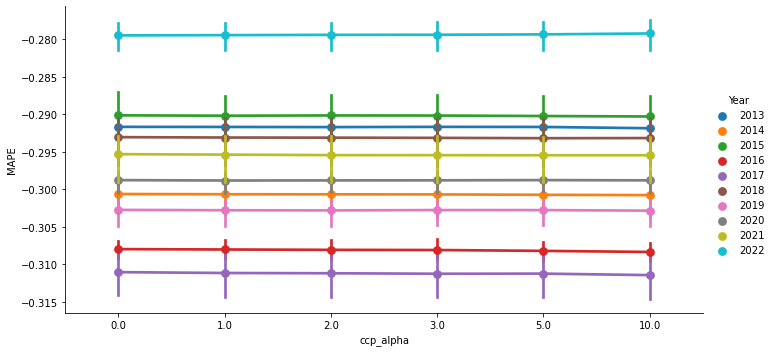

In [81]:
sns.catplot(x='ccp_alpha', y='MAPE', data=param_dfs['RF'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='gamma', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='C', y='MAPE', data=param_dfs['SVR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='min_samples_split', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='learning_rate', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

In [ ]:
sns.catplot(x='max_features', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)

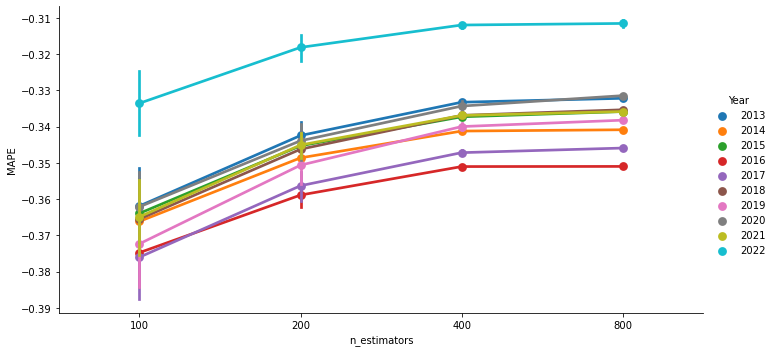

In [36]:
sns.catplot(x='n_estimators', y='MAPE', data=param_dfs['GBR'], hue='Year', kind='point', aspect=2)